In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import joblib

In [2]:
df_train = pd.read_csv("..\\Datasets\\Final_Training_set.csv")
df_test = pd.read_csv("..\\Datasets\\Final_Test_set.csv")

In [3]:
X_train = df_train.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)

y_train = df_train['price']
y_test = df_test['price']

In [4]:
kf = 10

In [5]:
def analyze_importance_distribution(series, threshold=0.8, plot=True, normalize=True):
    freq = series.sort_values(ascending=False)
    if normalize:
        freq = freq / freq.sum()
    
    cum_freq = freq.cumsum()
    
    summary_df = pd.DataFrame({
        'importance': freq,
        'cumulative': cum_freq
    })

    lorenz_y = np.insert(np.cumsum(np.sort(freq.values)), 0, 0)
    lorenz_y = lorenz_y / lorenz_y[-1]
    lorenz_x = np.linspace(0, 1, len(lorenz_y))
    gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)

    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,6))
        plt.plot(lorenz_x, lorenz_y, label='Lorenz Curve')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Line of Equality')
        plt.title('Lorenz Curve of Feature Importances')
        plt.xlabel('Cumulative Share of Features')
        plt.ylabel('Cumulative Share of Importance')
        plt.grid(True)
        plt.legend()
        plt.text(0.05, 0.8, f'Gini Coefficient: {gini:.4f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        plt.show()

    top_features = summary_df[summary_df['cumulative'] <= threshold].index.tolist()

    print(f"Top features (cover {threshold*100}%):")
    for f in top_features:
        print(f" - {f} (importance = {summary_df.loc[f, 'importance']:.4f})")

    return {
        'summary_df': summary_df,
        'top_features': top_features,
        'gini_coefficient': gini
    }


In [6]:
original_y_train = np.expm1(y_train)
original_y_test = np.expm1(y_test)

# 1. Linear Regression

In [7]:
linear_model = LinearRegression() 

In [8]:
linear_cv = cross_val_predict(linear_model, X_train, y_train, cv=kf)

linear_cv_r2 = r2_score(original_y_train, np.expm1(linear_cv))
linear_cv_mae = mean_absolute_error(original_y_train, np.expm1(linear_cv))
linear_cv_mse = mean_squared_error(original_y_train, np.expm1(linear_cv))
linear_cv_rmse = np.sqrt(linear_cv_mse)

In [9]:
pd.DataFrame({
    'R2': linear_cv_r2,
    'MAE': linear_cv_mae,
    'MSE': linear_cv_mse,
    'RMSE': linear_cv_rmse
}, index=[0])

,R2,MAE,MSE,RMSE
0,0.020936,1.493702e+06,1.197296e+15,3.460197e+07


### We cannot use linear model for this dataset since in data analysis step we can see that, the features do not have a strong linear relationship with the target variable

# 2. KNN Regression

In [11]:
KNN_model = KNeighborsRegressor()
KNN_params = {
    'n_neighbors': [3, 5, 7, 9, 11,13,15,17,19],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

KNN_grid_r2 = GridSearchCV(KNN_model, KNN_params, cv=kf, scoring='r2')
KNN_grid_r2.fit(X_train, y_train)
KNN_best_model_r2 = KNN_grid_r2.best_estimator_

In [13]:
KNN_model = KNeighborsRegressor()
KNN_params = {
    'n_neighbors': [3, 5, 7, 9, 11,13,15,17,19],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

KNN_grid_mae = GridSearchCV(KNN_model, KNN_params, cv=kf, scoring='neg_mean_absolute_error')
KNN_grid_mae.fit(X_train, y_train)
KNN_best_model_mae = KNN_grid_mae.best_estimator_

In [14]:
KNN_model = KNeighborsRegressor()
KNN_params = {
    'n_neighbors': [3, 5, 7, 9, 11,13,15,17,19],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

KNN_grid_mse = GridSearchCV(KNN_model, KNN_params, cv=kf, scoring='neg_mean_squared_error')
KNN_grid_mse.fit(X_train, y_train)
KNN_best_model_mse = KNN_grid_mse.best_estimator_

In [15]:
print("best model using r2 score",KNN_grid_r2.best_params_)
print("best model using mae",KNN_grid_mae.best_params_)
print("best model using mse",KNN_grid_mse.best_params_)

best model using r2 score {'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
best model using mae {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
best model using mse {'n_neighbors': 15, 'p': 2, 'weights': 'distance'}


In [16]:
KNN_best_models = {
    "r2_model": KNeighborsRegressor(n_neighbors=19, p=1, weights='uniform'),
    "mae_model": KNeighborsRegressor(n_neighbors=9, p=1, weights='distance'),
    "mse_model": KNeighborsRegressor(n_neighbors=11, p=2, weights='uniform'),
}

for name, model in KNN_best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_original = np.expm1(y_pred)

    r2 = r2_score(original_y_test, y_pred_original)
    mae = mean_absolute_error(original_y_test, y_pred_original)
    mse = mean_squared_error(original_y_test, y_pred_original)
    rmse = np.sqrt(mse)

    print(f"{name}:")
    print(f"  R²    = {r2:.4f}")
    print(f"  MAE   = {mae:.4f}")
    print(f"  MSE   = {mse:.4f}")
    print(f"  RMSE  = {rmse:.4f}")
    print("-" * 30)


r2_model:
  R²    = 0.4047
  MAE   = 892292.0646
  MSE   = 14997356055937.6621
  RMSE  = 3872641.9995
------------------------------
mae_model:
  R²    = 0.4698
  MAE   = 831230.8083
  MSE   = 13359485853644.4199
  RMSE  = 3655063.0437
------------------------------
mse_model:
  R²    = 0.4737
  MAE   = 873225.7766
  MSE   = 13258940159040.4766
  RMSE  = 3641282.7629
------------------------------


# 3. Random Forest and Feature Selection using Feature Importance

In [17]:
random_forest_model = RandomForestRegressor()

random_forest_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [18]:
random_forest_random_r2 = RandomizedSearchCV(random_forest_model, random_forest_params, cv=kf, scoring='r2', n_iter=20)
random_forest_random_r2.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   scoring='r2')

In [19]:
rf_best_model_r2 = random_forest_random_r2.best_estimator_

In [20]:
random_forest_random_mae = RandomizedSearchCV(random_forest_model, random_forest_params, cv=kf, scoring='neg_mean_absolute_error', n_iter=20)
random_forest_random_mae.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   scoring='neg_mean_absolute_error')

In [21]:
rf_best_model_mae = random_forest_random_mae.best_estimator_

In [22]:
random_forest_random_mse = RandomizedSearchCV(random_forest_model, random_forest_params, cv=kf, scoring='neg_mean_squared_error', n_iter=20)
random_forest_random_mse.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   scoring='neg_mean_squared_error')

In [23]:
rf_best_model_mse = random_forest_random_mse.best_estimator_

In [24]:
rf_best_param_mse = random_forest_random_mse.best_params_
rf_best_param_r2 = random_forest_random_r2.best_params_
rf_best_param_mae = random_forest_random_mae.best_params_

In [25]:
print("best model using r2 score",rf_best_param_r2)
print("best model using mae",rf_best_param_mae)
print("best model using mse",rf_best_param_mse)

best model using r2 score {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
best model using mae {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
best model using mse {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


In [26]:
# choosing mae model since our goal is to predict exact price of almost every house
# if choosing mse model, it will be more sensitive to outliers, the model will try to minimize the error of outliers leading to decrease in performance

rf_best_model = RandomForestRegressor(n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 'log2', max_depth = 30)
rf_best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='log2', n_estimators=50)

In [27]:
importances = rf_best_model.feature_importances_

feature_names = X_train.columns
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})

C:\Users\Nobody\AppData\Local\Temp\ipykernel_16372\3681630074.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)


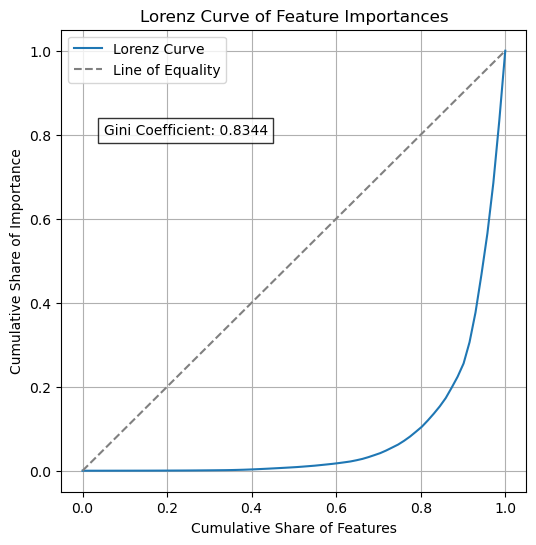

Top features (cover 80.0%):
 - 66 (importance = 0.1660)
 - 67 (importance = 0.1485)
 - 69 (importance = 0.1205)
 - 65 (importance = 0.0979)
 - 68 (importance = 0.0903)
 - 62 (importance = 0.0707)
 - 70 (importance = 0.0506)
 - 24 (importance = 0.0314)


{'summary_df':     importance  cumulative
 66    0.165951    0.165951
 67    0.148504    0.314456
 69    0.120503    0.434958
 65    0.097939    0.532897
 68    0.090349    0.623246
 ..         ...         ...
 34    0.000017    0.999971
 51    0.000013    0.999984
 49    0.000007    0.999991
 43    0.000005    0.999996
 42    0.000004    1.000000
 
 [71 rows x 2 columns],
 'top_features': [66, 67, 69, 65, 68, 62, 70, 24],
 'gini_coefficient': np.float64(0.8344366167996145)}

In [28]:
analyze_importance_distribution(feat_imp['importance'], threshold=0.8, plot=True, normalize=True)

In [29]:
important_indices = [66, 67, 68, 69, 65, 64]
X_train_subset = X_train.iloc[:, important_indices]

In [30]:
X_train_subset.head()

,bath,propertysqft,latitude,longitude,beds,borough_Staten Island
0,-0.584963,0.000000,0.219838,1.903102,-1.356915,0.0
1,-0.584963,0.000000,1.357802,0.383686,-1.356915,0.0
2,0.000000,0.000000,0.438858,1.513024,-0.563171,0.0
3,-0.584963,-0.623029,-0.158930,0.808685,0.000000,0.0
4,0.415037,0.314607,0.018349,0.391071,0.793745,0.0


In [31]:
rf_final= RandomForestRegressor(n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 'log2', max_depth = 30)
rf_final.fit(X_train_subset, y_train)

RandomForestRegressor(max_depth=30, max_features='log2', n_estimators=50)

In [32]:
rf_final_pred = np.expm1(rf_final.predict(X_test.iloc[:, important_indices]))
rf_final_r2 = r2_score(original_y_test, rf_final_pred)
rf_final_mae = mean_absolute_error(original_y_test, rf_final_pred)
rf_final_mse = mean_squared_error(original_y_test, rf_final_pred)

In [33]:
pd.DataFrame({
    'R2': rf_final_r2,
    'MAE': rf_final_mae,
    'MSE': rf_final_mse,
    'RMSE': np.sqrt(rf_final_mse)
}, index=[0])

,R2,MAE,MSE,RMSE
0,0.506878,774483.400598,1.242412e+13,3.524786e+06


In [34]:
rf_final_2 = RandomForestRegressor(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 1, max_features = 'log2', max_depth = 30)
rf_final_2.fit(X_train_subset, y_train)
rf_final_pred_2 = np.expm1(rf_final_2.predict(X_test.iloc[:, important_indices]))

In [35]:
rf_final_2_r2 = r2_score(original_y_test, rf_final_pred_2)
rf_final_2_mae = mean_absolute_error(original_y_test, rf_final_pred_2)
rf_final_2_mse = mean_squared_error(original_y_test, rf_final_pred_2)
pd.DataFrame({
    'R2': rf_final_2_r2,
    'MAE': rf_final_2_mae,
    'MSE': rf_final_2_mse,
    'RMSE': np.sqrt(rf_final_2_mse)
}, index=[0])

,R2,MAE,MSE,RMSE
0,0.51574,761673.701827,1.220084e+13,3.492970e+06


In [36]:
rf_final_3 = RandomForestRegressor(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 20)
rf_final_3.fit(X_train_subset, y_train)
rf_final_pred_3 = np.expm1(rf_final_2.predict(X_test.iloc[:, important_indices]))

In [37]:
rf_final_3_r2 = r2_score(original_y_test, rf_final_pred_3)
rf_final_3_mae = mean_absolute_error(original_y_test, rf_final_pred_3)
rf_final_3_mse = mean_squared_error(original_y_test, rf_final_pred_3)
pd.DataFrame({
    'R2': rf_final_3_r2,
    'MAE': rf_final_3_mae,
    'MSE': rf_final_3_mse,
    'RMSE': np.sqrt(rf_final_3_mse)
}, index=[0])

,R2,MAE,MSE,RMSE
0,0.51574,761673.701827,1.220084e+13,3.492970e+06


# 4. LGBM

In [38]:
lgbm_model = LGBMRegressor()
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 10, 20],
    'min_child_samples': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0]
}

In [39]:
lgbm_random_r2 = RandomizedSearchCV(lgbm_model, lgbm_params, cv=kf, scoring='r2', n_iter=20)
lgbm_random_r2.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 49
[LightGBM] [Info] Start training from score 13.759746
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 49
[LightGBM] [Info] Start training from score 13.751745
[LightGBM] [Warning] Found whi

RandomizedSearchCV(cv=10, estimator=LGBMRegressor(), n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [None, 10, 20],
                                        'min_child_samples': [1, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='r2')

In [40]:
lgbm_random_mae = RandomizedSearchCV(lgbm_model, lgbm_params, cv=kf, scoring='neg_mean_absolute_error', n_iter=20)
lgbm_random_mae.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 71
[LightGBM] [Info] Start training from score 13.759746
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 70
[LightGBM] [Info] Start training from score 13.751745
[LightGBM] [Warning] Found whi

RandomizedSearchCV(cv=10, estimator=LGBMRegressor(), n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [None, 10, 20],
                                        'min_child_samples': [1, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_absolute_error')

In [41]:
lgbm_random_mse = RandomizedSearchCV(lgbm_model, lgbm_params, cv=kf, scoring='neg_mean_squared_error', n_iter=20)
lgbm_random_mse.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 46
[LightGBM] [Info] Start training from score 13.759746
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 46
[LightGBM] [Info] Start training from score 13.751745
[LightGBM] [Warning] Found whi

RandomizedSearchCV(cv=10, estimator=LGBMRegressor(), n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [None, 10, 20],
                                        'min_child_samples': [1, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_squared_error')

In [42]:
lbgm_r2_importance = lgbm_random_r2.best_estimator_.feature_importances_
lbgm_mae_importance = lgbm_random_mae.best_estimator_.feature_importances_ 
lbgm_mse_importance = lgbm_random_mse.best_estimator_.feature_importances_

C:\Users\Nobody\AppData\Local\Temp\ipykernel_16372\3681630074.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)


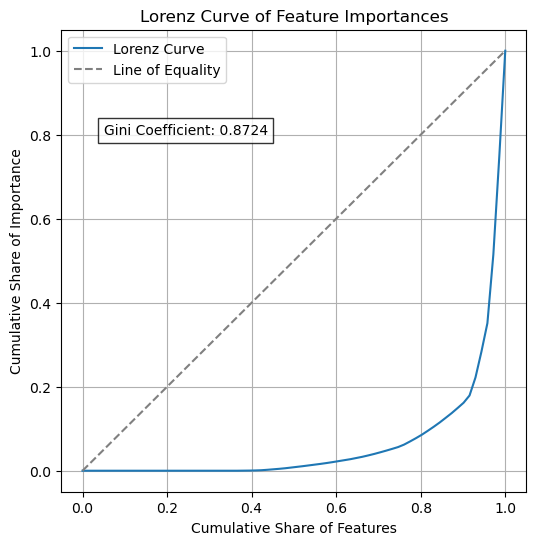

Top features (cover 80.0%):
 - 68 (importance = 0.2512)
 - 69 (importance = 0.2338)
 - 67 (importance = 0.1637)
 - 70 (importance = 0.0677)
 - 65 (importance = 0.0615)


{'summary_df':     importance  cumulative
 68    0.251167    0.251167
 69    0.233833    0.485000
 67    0.163667    0.648667
 70    0.067667    0.716333
 65    0.061500    0.777833
 ..         ...         ...
 43    0.000000    1.000000
 40    0.000000    1.000000
 39    0.000000    1.000000
 55    0.000000    1.000000
 58    0.000000    1.000000
 
 [71 rows x 2 columns],
 'top_features': [68, 69, 67, 70, 65],
 'gini_coefficient': np.float64(0.8724460093896714)}

In [43]:
lgbm_feature_names = X_train.columns
feat_imp_lgbm_r2 = pd.DataFrame({'feature': lgbm_feature_names, 'importance': lbgm_r2_importance})

analyze_importance_distribution(feat_imp_lgbm_r2['importance'], threshold=0.8, plot=True, normalize=True)

C:\Users\Nobody\AppData\Local\Temp\ipykernel_16372\3681630074.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)


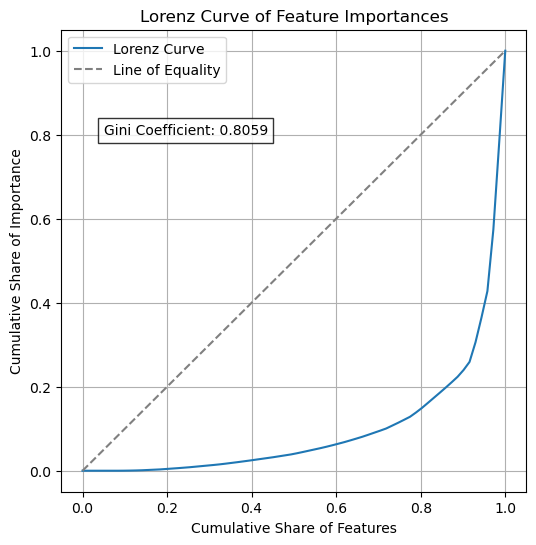

Top features (cover 80.0%):
 - 69 (importance = 0.2146)
 - 68 (importance = 0.2112)
 - 67 (importance = 0.1466)
 - 70 (importance = 0.0632)
 - 65 (importance = 0.0587)
 - 66 (importance = 0.0467)
 - 24 (importance = 0.0192)
 - 28 (importance = 0.0161)
 - 27 (importance = 0.0131)


{'summary_df':     importance  cumulative
 69    0.214556    0.214556
 68    0.211222    0.425778
 67    0.146556    0.572333
 70    0.063222    0.635556
 65    0.058667    0.694222
 ..         ...         ...
 35    0.000000    1.000000
 38    0.000000    1.000000
 48    0.000000    1.000000
 43    0.000000    1.000000
 47    0.000000    1.000000
 
 [71 rows x 2 columns],
 'top_features': [69, 68, 67, 70, 65, 66, 24, 28, 27],
 'gini_coefficient': np.float64(0.8059092331768388)}

In [44]:
feat_imp_lgbm_mae = pd.DataFrame({'feature': lgbm_feature_names, 'importance': lbgm_mae_importance})

analyze_importance_distribution(feat_imp_lgbm_mae['importance'], threshold=0.8, plot=True, normalize=True)

C:\Users\Nobody\AppData\Local\Temp\ipykernel_16372\3681630074.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)


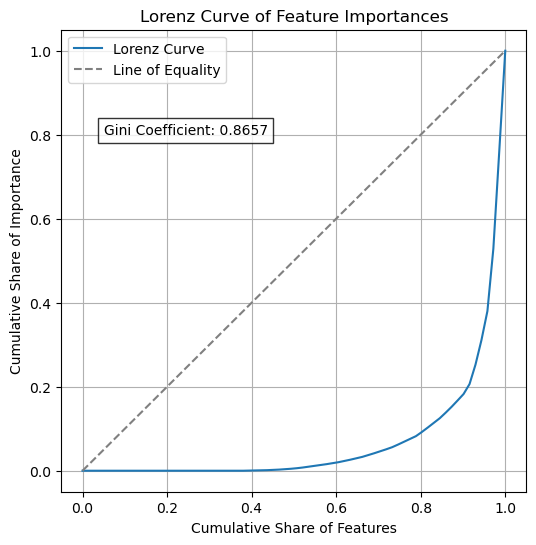

Top features (cover 80.0%):
 - 68 (importance = 0.2373)
 - 69 (importance = 0.2340)
 - 67 (importance = 0.1487)
 - 70 (importance = 0.0690)
 - 65 (importance = 0.0583)
 - 66 (importance = 0.0463)


{'summary_df':     importance  cumulative
 68    0.237333    0.237333
 69    0.234000    0.471333
 67    0.148667    0.620000
 70    0.069000    0.689000
 65    0.058333    0.747333
 ..         ...         ...
 43    0.000000    1.000000
 40    0.000000    1.000000
 39    0.000000    1.000000
 55    0.000000    1.000000
 58    0.000000    1.000000
 
 [71 rows x 2 columns],
 'top_features': [68, 69, 67, 70, 65, 66],
 'gini_coefficient': np.float64(0.8656525821596245)}

In [45]:
feat_imp_lgbm_mse = pd.DataFrame({'feature': lgbm_feature_names, 'importance': lbgm_mse_importance})

analyze_importance_distribution(feat_imp_lgbm_mse['importance'], threshold=0.8, plot=True, normalize=True)

In [46]:
lgbm_X_train_subset = X_train.iloc[:, important_indices]
lgbm_X_test_subset = X_test.iloc[:, important_indices]

In [47]:
lgbm_random_best_model_r2 = lgbm_random_r2.best_params_
lgbm_random_best_model_mae = lgbm_random_mae.best_params_
lgbm_random_best_model_mse = lgbm_random_mse.best_params_

print("best model using r2 score",lgbm_random_best_model_r2)
print("best model using mae",lgbm_random_best_model_mae)    
print("best model using mse",lgbm_random_best_model_mse)

best model using r2 score {'subsample': 0.8, 'n_estimators': 200, 'min_child_samples': 10, 'max_depth': None, 'learning_rate': 0.1}
best model using mae {'subsample': 1.0, 'n_estimators': 300, 'min_child_samples': 1, 'max_depth': 10, 'learning_rate': 0.1}
best model using mse {'subsample': 0.6, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 20, 'learning_rate': 0.1}


In [48]:
final_lgbm_model_1_r2 = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=None, min_child_samples=5, subsample=0.6)
final_lgbm_model_1_r2.fit(lgbm_X_train_subset, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 3839, number of used features: 6
[LightGBM] [Info] Start training from score 13.754460


LGBMRegressor(max_depth=None, min_child_samples=5, n_estimators=200,
              subsample=0.6)

In [49]:
final_lgbm_model_2_mae = LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=None, min_child_samples=5, subsample=1)
final_lgbm_model_2_mae.fit(lgbm_X_train_subset, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 3839, number of used features: 6
[LightGBM] [Info] Start training from score 13.754460


LGBMRegressor(max_depth=None, min_child_samples=5, n_estimators=300,
              subsample=1)

In [50]:
final_lgbm_model_3_mse = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=None, min_child_samples=5, subsample=0.6)
final_lgbm_model_3_mse.fit(lgbm_X_train_subset, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 3839, number of used features: 6
[LightGBM] [Info] Start training from score 13.754460


LGBMRegressor(max_depth=None, min_child_samples=5, n_estimators=200,
              subsample=0.6)

In [51]:
final_lgbm_pred_1_r2 = np.expm1(final_lgbm_model_1_r2.predict(lgbm_X_test_subset))
final_lgbm_pred_2_mae = np.expm1(final_lgbm_model_2_mae.predict(lgbm_X_test_subset))
final_lgbm_pred_3_mse = np.expm1(final_lgbm_model_3_mse.predict(lgbm_X_test_subset))

In [52]:
final_lgbm_1_r2_r2 = r2_score(original_y_test, final_lgbm_pred_1_r2)
final_lgbm_1_r2_mae = mean_absolute_error(original_y_test, final_lgbm_pred_1_r2)
final_lgbm_1_r2_mse = mean_squared_error(original_y_test, final_lgbm_pred_1_r2)

final_lgbm_2_mae_r2 = r2_score(original_y_test, final_lgbm_pred_2_mae)
final_lgbm_2_mae_mae = mean_absolute_error(original_y_test, final_lgbm_pred_2_mae)
final_lgbm_2_mae_mse = mean_squared_error(original_y_test, final_lgbm_pred_2_mae)

final_lgbm_3_mse_r2 = r2_score(original_y_test, final_lgbm_pred_3_mse)
final_lgbm_3_mse_mae = mean_absolute_error(original_y_test, final_lgbm_pred_3_mse)
final_lgbm_3_mse_mse = mean_squared_error(original_y_test, final_lgbm_pred_3_mse)

pd.DataFrame({
    'R2': [final_lgbm_1_r2_r2, final_lgbm_2_mae_r2, final_lgbm_3_mse_r2],
    'MAE': [final_lgbm_1_r2_mae, final_lgbm_2_mae_mae, final_lgbm_3_mse_mae],
    'MSE': [final_lgbm_1_r2_mse, final_lgbm_2_mae_mse, final_lgbm_3_mse_mse],
    'RMSE': [np.sqrt(final_lgbm_1_r2_mse), np.sqrt(final_lgbm_2_mae_mse), np.sqrt(final_lgbm_3_mse_mse)]
}, index=['LGBM Model 1 (R²)', 'LGBM Model 2 (MAE)', 'LGBM Model 3 (MSE)'])


,R2,MAE,MSE,RMSE
LGBM Model 1 (R²),0.575503,722301.418302,1.069513e+13,3.270341e+06
LGBM Model 2 (MAE),0.580829,711646.094940,1.056096e+13,3.249762e+06
LGBM Model 3 (MSE),0.575503,722301.418302,1.069513e+13,3.270341e+06


# 5. Save final model and column

In [53]:
joblib.dump(final_lgbm_model_2_mae, '..\\Model\\lgbm.pkl')

['..\\Model\\lgbm.pkl']

In [54]:
joblib.dump(lgbm_X_train_subset, '..\\Model\\columns.pkl')

['..\\Model\\columns.pkl']

In [55]:
lgbm_X_train_subset.columns

Index(['bath', 'propertysqft', 'latitude', 'longitude', 'beds',
       'borough_Staten Island'],
      dtype='object')